# RNA segmentation

In this tutorial, we will assume we only have the RNA image available without any staining and attempt to use the RNA signal to identify single cells.

<div class="alert alert-info">

See also

[RNA segmentation](../../technicals/cell_segmentation.md#rna-segmentation)

</div>

This is done in the following steps.

1. Identify nuclei using nuclear-localized genes (in our case, we'll use the `Malat1` and `Neat1` genes).
2. Identify additional nuclei using unspliced RNA.
3. [Optional] Expand the nuclei labels to cytoplasm.

In [1]:
import starro as star

from skimage.color import label2rgb
import matplotlib.pyplot as plt

star.config.n_threads = 8
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

2023-03-29 16:18:41.141382: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-29 16:18:41.187253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 16:18:41.794700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
auto.py (21): IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Load the data

We will be using a truncated mouse coronal section dataset from [Chen et al., 2021](https://doi.org/10.1101/2021.01.17.427004).

In [2]:
#!wget "https://drive.google.com/uc?export=download&id=18sM-5LmxOgt-3kq4ljtq_EdWHjihvPUx" -nc -O SS200000135TL_D1_all_bin1.txt.gz

Load the downloaded UMI counts and nuclei staining image into an AnnData object. For the purposes of cell segmentation, we will be working with an aggregated counts matrix, where the `obs` and `var` of the AnnData correspond to the spatial X and Y coordinates, and each element of the matrix contains the total number of UMIs captured for each X and Y coordinate.

<div class="alert alert-info">
Note
    
We will be using the `Malat1` gene and unspliced RNA to identify nuclei. We are providing the `gene_agg` argument so that the resulting AnnData will have a layer containing combined `Malat1` and `Neat1` counts.
    
</div>

In [3]:
adata = star.read_bgi_agg(
    'SS200000135TL_D1_all_bin1.txt.gz',
    gene_agg={'nuclear': ['Malat1', 'Neat1']}  # Add a layer for nuclear-localized genes
)
adata

|-----> Constructing count matrices.
|-----> Aggregating counts for genes provided by `gene_agg`.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


io.py (287): X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


AnnData object with n_obs × n_vars = 2000 × 2000
    uns: '__type', 'pp', 'spatial'
    layers: 'spliced', 'unspliced', 'nuclear'

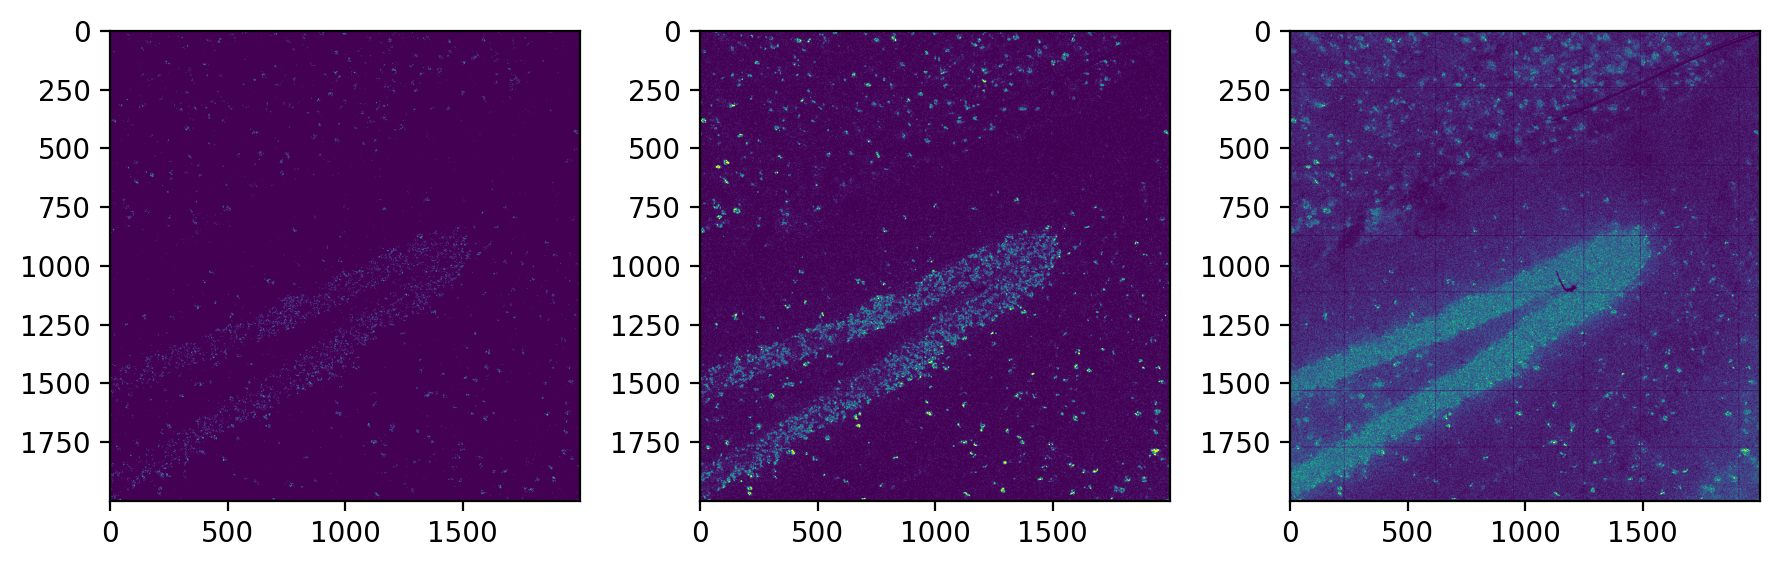

In [4]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(adata.layers['nuclear'].A, vmax=2)
axes[1].imshow(adata.layers['unspliced'].A, vmax=5)
axes[2].imshow(adata.X.A, vmax=10)

## Identify nuclei with nuclear localized genes

### Density binning

As we can observe above, there are regions of high and low RNA density. This requires separating the image into several density regions, and then running segmentation on each region separately. Otherwise, the algorithm is likely to be mis-calibrated and be too sensitive in RNA-rich regions and too strict in RNA-sparse regions.

We recommend first starting off with a lenient (a.k.a. split the pixels into many RNA density regions) and then merging regions manually.

|-----> <select> nuclear layer in AnnData Object
|-----> Finding density bins.
|-----> <insert> nuclear_bins to layers in AnnData Object.


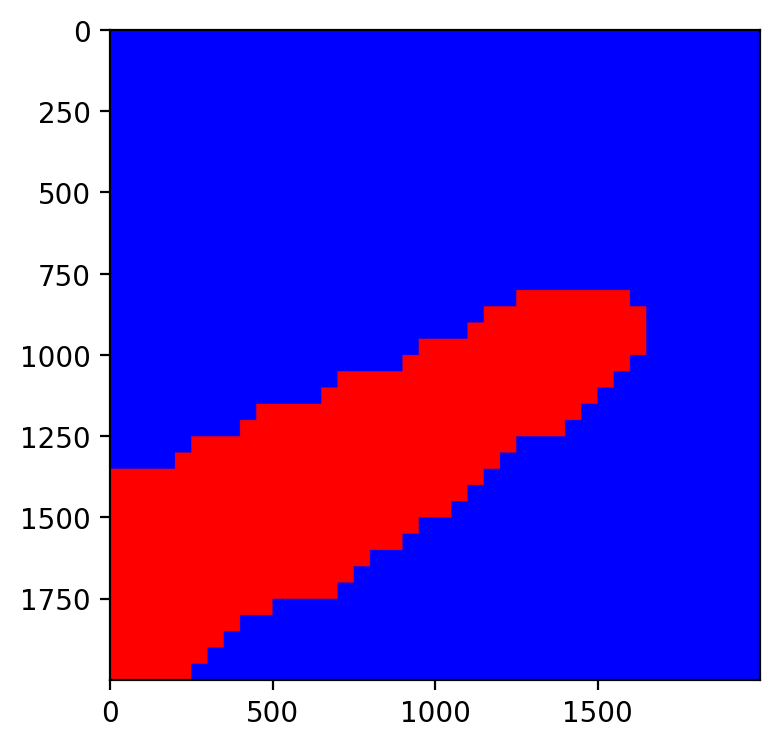

In [5]:
star.segment_densities(adata, 'nuclear', 50, k=3, dk=3, distance_threshold=3, background=False)

fig, axes = plt.subplots(ncols=1, figsize=(4, 4), tight_layout=True)
axes.imshow(label2rgb(adata.layers['nuclear_bins']))

### Segmentation

<div class="alert alert-info">
Note
    
In this tutorial, we will be using the `VI+BP` method exclusively, but there are other methods available. See [Segmentation approaches](../../technicals/cell_segmentation.md#segmentation-approaches)

</div>

|-----> <select> nuclear layer in AnnData Object
|-----> <select> nuclear_bins layer in AnnData Object
|-----> Scoring pixels with vi+bp method.
|-----? Bin 1 estimated variance of background (3.07e-02) is less than the mean (3.17e-02). Initial variance will be arbitrarily set to 1.1x of the mean. This is usually due to extreme sparsity. Please consider increasing `k` or using the zero-inflated distribution.


Loss 1.3643e-01: 100%|██████████| 500/500 [00:12<00:00, 39.96it/s]


|-----> <insert> nuclear_scores to layers in AnnData Object.
|-----> Applying threshold 0.5024065280490122.
threshold: 0.5024065280490122
|-----> <insert> nuclear_mask to layers in AnnData Object.


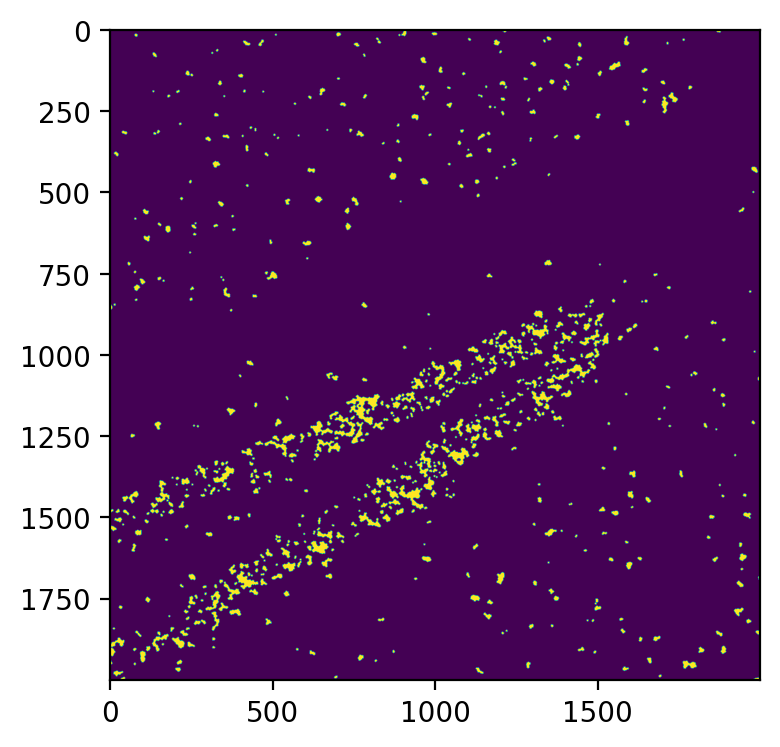

In [6]:
star.score_and_mask_pixels(
    adata, 'nuclear', k=5, method='VI+BP',
    vi_kwargs=dict(downsample=0.1, seed=0, zero_inflated=True)
)

fig, axes = plt.subplots(ncols=1, figsize=(4, 4), tight_layout=True)
axes.imshow(adata.layers['nuclear_mask'])

### Labeling

|-----> <select> nuclear_mask layer in AnnData Object
|-----> Finding peaks with minimum distance 7.
|-----> <insert> nuclear_distances to layers in AnnData Object.
|-----> <insert> nuclear_markers to layers in AnnData Object.
|-----> <select> nuclear_distances layer in AnnData Object
|-----> <select> nuclear_mask layer in AnnData Object
|-----> <select> nuclear_markers layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> nuclear_labels to layers in AnnData Object.


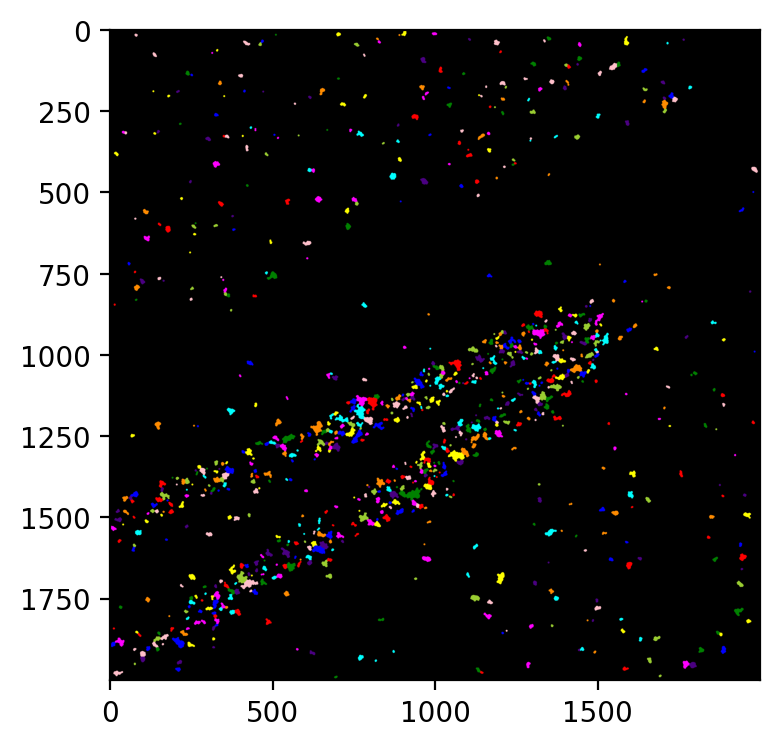

In [7]:
star.find_peaks_from_mask(adata, 'nuclear', 7)
star.watershed(
    adata, 'nuclear_distances', 1,
    mask_layer='nuclear_mask',
    markers_layer='nuclear_markers',
    out_layer='nuclear_labels'
)

fig, axes = plt.subplots(ncols=1, figsize=(4, 4), tight_layout=True)
axes.imshow(label2rgb(adata.layers['nuclear_labels']))

## Identify additional nuclei with unspliced RNA

### Density binnning

|-----> <select> unspliced layer in AnnData Object
|-----> Finding density bins.
|-----> <insert> unspliced_bins to layers in AnnData Object.


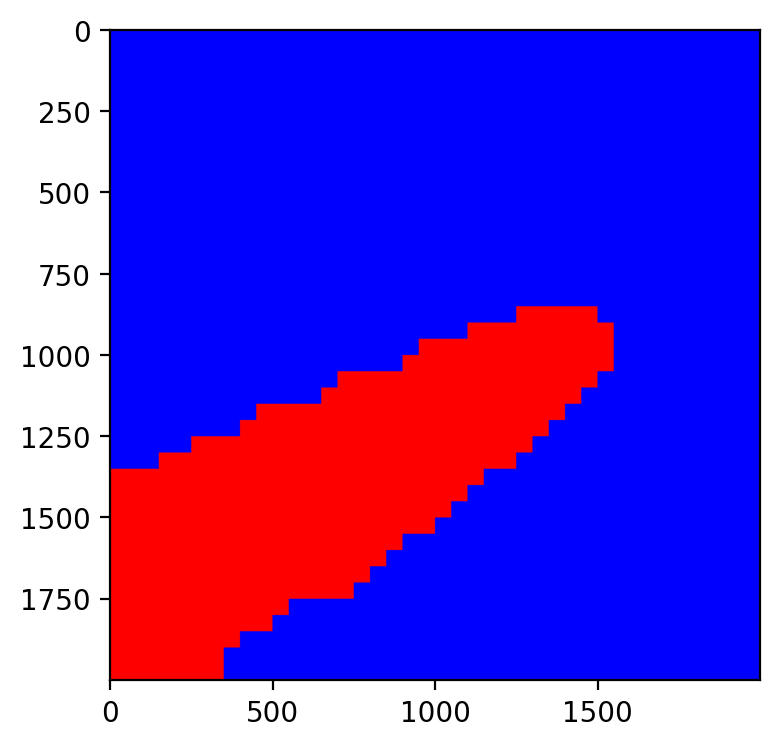

In [8]:
star.segment_densities(adata, 'unspliced', 50, k=3, dk=3, distance_threshold=3, background=False)

fig, axes = plt.subplots(ncols=1, figsize=(4, 4), tight_layout=True)
axes.imshow(label2rgb(adata.layers['unspliced_bins']))

### Segmentation

Then, as we did previously for the nuclear gene counts, identify nuclei using unspliced RNA. Note that the function will automatically detect the RNA density bins and adjust the algorithm accordingly. Also, note that we provide the `certain_layer` argument to `st.pp.segmentation.score_and_mask_pixels` and the `seed_layer` argument to `st.pp.segmentation.label_connected_components` to indicate the nuclei labels obtained from nuclear localized genes. Internally, these labels are used to further aid the identification of real nuclei.

|-----> <select> unspliced layer in AnnData Object
|-----> <select> nuclear_labels layer in AnnData Object
|-----> <select> unspliced_bins layer in AnnData Object
|-----> Scoring pixels with vi+bp method.


Loss 1.6428e+00: 100%|██████████| 500/500 [00:12<00:00, 41.07it/s]
vi.py (159): To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


|-----> <insert> unspliced_scores to layers in AnnData Object.
|-----> Applying threshold 0.4605137851660849.
threshold: 0.4605137851660849
|-----> <insert> unspliced_mask to layers in AnnData Object.


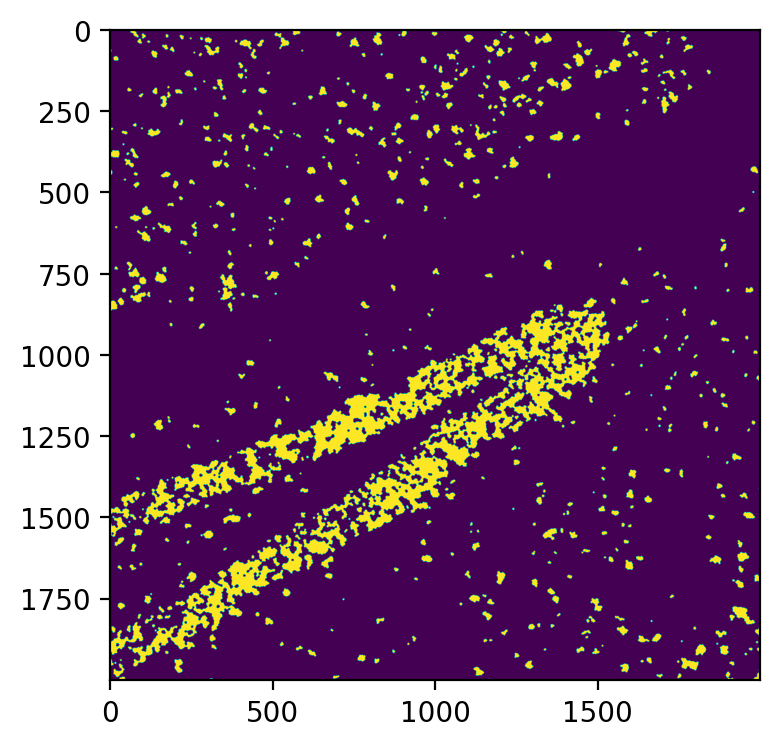

In [9]:
star.score_and_mask_pixels(
    adata, 'unspliced', k=5, method='VI+BP',
    vi_kwargs=dict(downsample=0.1, seed=0),
    certain_layer='nuclear_labels'
)

fig, axes = plt.subplots(ncols=1, figsize=(4, 4), tight_layout=True)
axes.imshow(adata.layers['unspliced_mask'])

### Labeling

Unlike previously when we used nuclear localized genes, here we know some initial labels that we would like to retain (and in some cases, make larger to fill the above mask). Additionally, using unspliced labels seems to over-saturate some RNA-dense areas, so much so that it is difficult to tell the boundaries of cells in these areas. Therefore, instead of using a Watershed approach, which would attempt to "fill up" the entire mask, we will use `st.cs.label_connected_components` to limit the maximum area each label can be assigned. 

Note that we provide the `seed_label` argument to be the labels we obtained previously using nuclear localized genes.

|-----> <select> unspliced_mask layer in AnnData Object
|-----> <select> nuclear_labels layer in AnnData Object


Eroding: 7it [00:00, 275.04it/s]
Expanding:   0%|          | 0/8 [00:00<?, ?it/s]2023-03-29 16:19:37.770121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-29 16:19:37.770121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-29 16:19:37.788483: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-29 16:19:37.933970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-29 16:19:37.933982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-29 16:19:37.948244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-29 16:19:37.948954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-29 16:19:38.191847: W tensorflow/compiler/t

|-----> <insert> unspliced_labels to layers in AnnData Object.


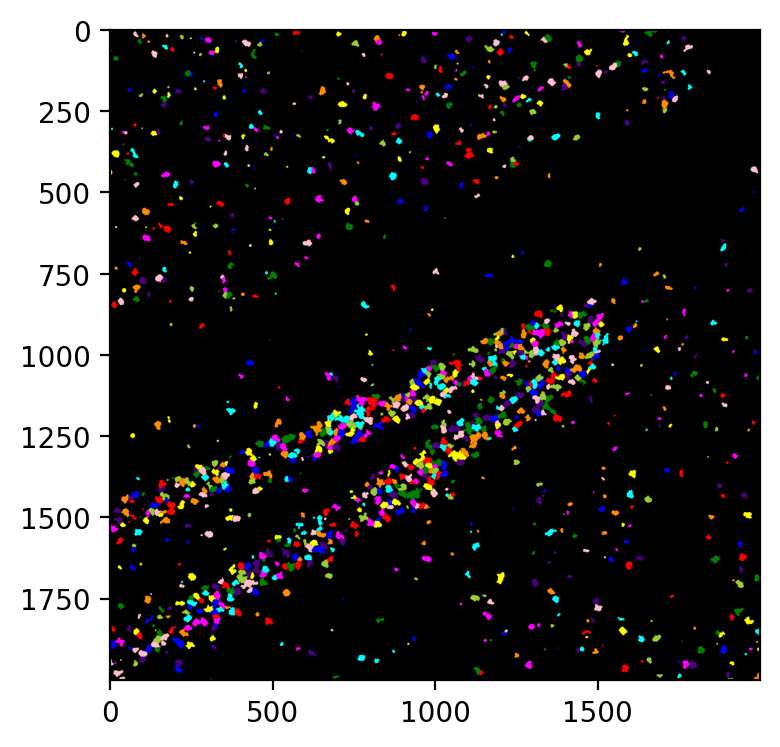

In [10]:
star.label_connected_components(adata, 'unspliced', seed_layer='nuclear_labels')

fig, axes = plt.subplots(ncols=1, figsize=(4, 4), tight_layout=True)
axes.imshow(label2rgb(adata.layers['unspliced_labels']))

## [Optional] Identify cytoplasm

Though it is possible to use the above labels directly as each nuclei, we would ideally like to expand these labels to cover the cytoplasm.

### Density binning

|-----> <select> X layer in AnnData Object
|-----> Finding density bins.
|-----> <insert> X_bins to layers in AnnData Object.


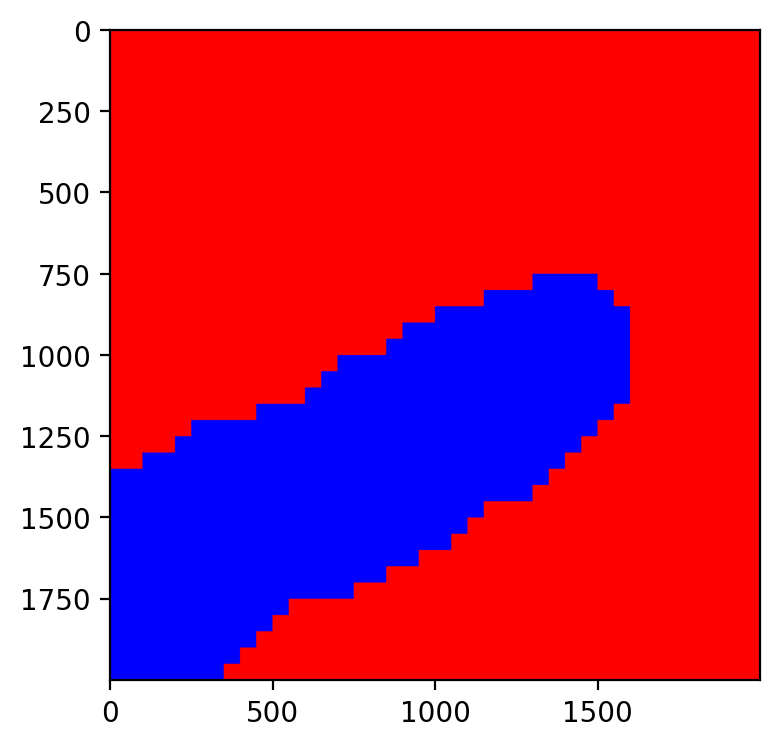

In [11]:
star.segment_densities(adata, 'X', 50, k=3, distance_threshold=3, dk=5, background=False)
fig, axes = plt.subplots(ncols=1, figsize=(4, 4), tight_layout=True)
axes.imshow(label2rgb(adata.layers['X_bins']))

### Segmentation

|-----> <select> X layer in AnnData Object
|-----> <select> unspliced_labels layer in AnnData Object
|-----> <select> X_bins layer in AnnData Object
|-----> Scoring pixels with vi+bp method.


Loss 4.9313e+00: 100%|██████████| 500/500 [00:05<00:00, 87.17it/s]


|-----> <insert> X_scores to layers in AnnData Object.
|-----> Applying threshold 0.4863116746597143.
threshold: 0.4863116746597143
|-----> <insert> X_mask to layers in AnnData Object.


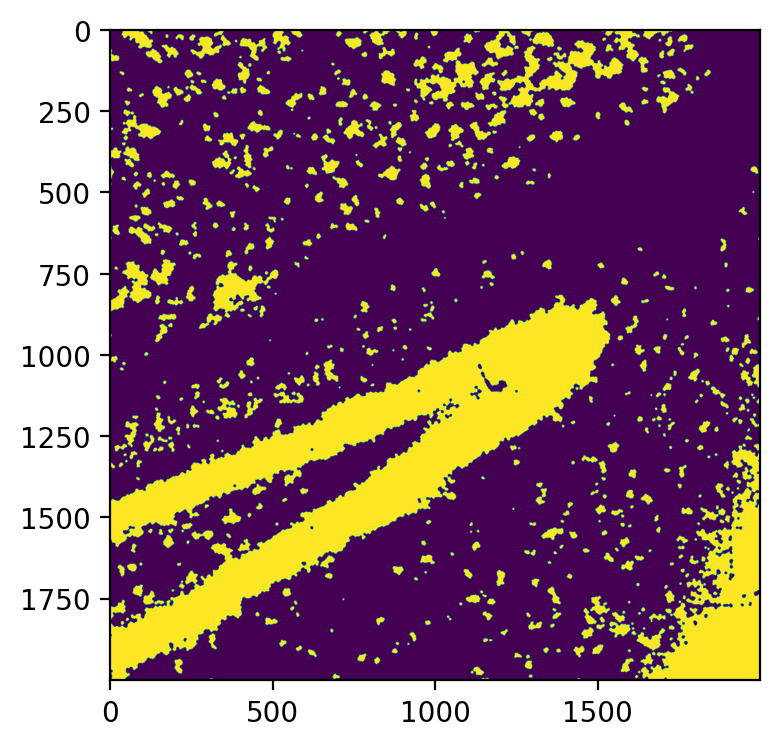

In [12]:
star.score_and_mask_pixels(
    adata, 'X', k=7, method='VI+BP',
    vi_kwargs=dict(downsample=0.1, seed=0),
    certain_layer='unspliced_labels'
)

fig, axes = plt.subplots(ncols=1, figsize=(4, 4), tight_layout=True)
axes.imshow(adata.layers['X_mask'])

### Labeling

|-----> <select> X_mask layer in AnnData Object
|-----> <select> unspliced_labels layer in AnnData Object


Eroding: 13it [00:00, 248.07it/s]
Expanding: 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]


|-----> <insert> X_labels to layers in AnnData Object.


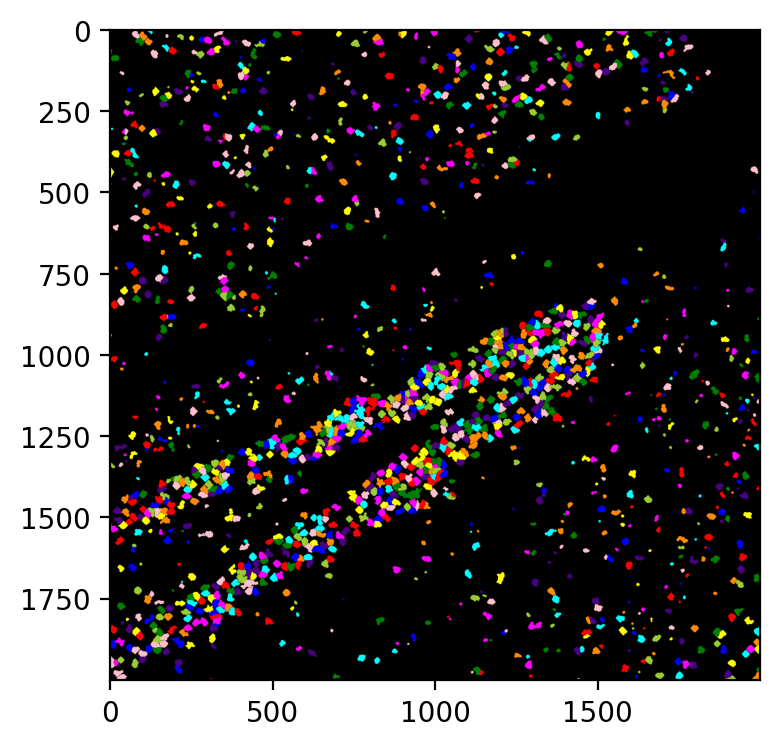

In [13]:
star.label_connected_components(adata, 'X', seed_layer='unspliced_labels')

fig, axes = plt.subplots(ncols=1, figsize=(4, 4), tight_layout=True)
axes.imshow(label2rgb(adata.layers['X_labels']))

## Getting a cell x gene matrix

Finally, we will use our segmentation results to obtain the desired cell-by-gene counts matrix.

But first, we will expand all the cell labels by some amount to mitigate the effects of RNA diffusion. The distance that should be expanded will depend on the level of RNA diffusion in the data.

|-----> <select> X_labels layer in AnnData Object
|-----> Expanding labels.


Expanding: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]

|-----> <insert> X_labels_expanded to layers in AnnData Object.


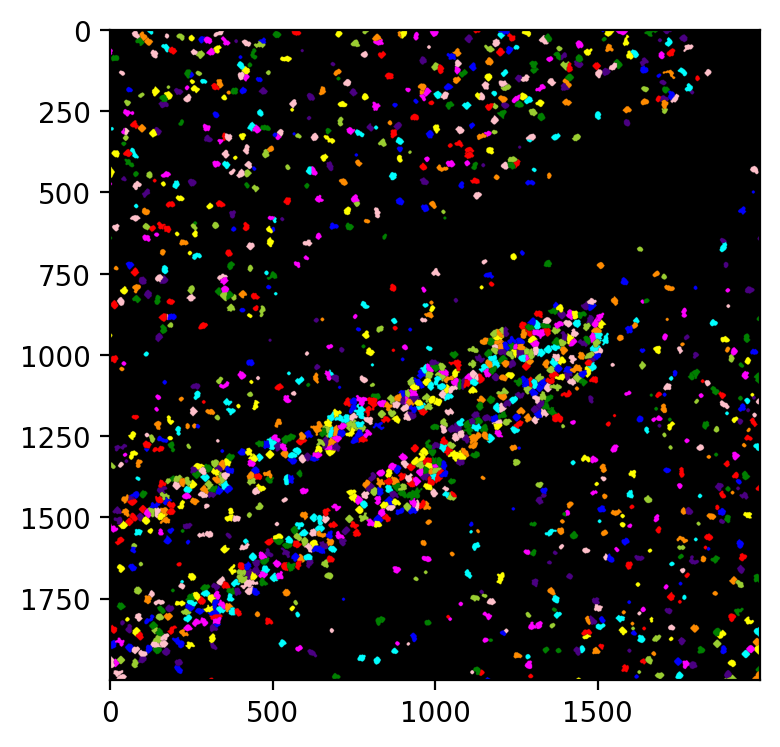

In [14]:
star.expand_labels(
    adata, 'X_labels', distance=2, out_layer='X_labels_expanded'
)

fig, axes = plt.subplots(ncols=1, figsize=(4, 4), tight_layout=True)
axes.imshow(label2rgb(adata.layers['X_labels_expanded']))